In [9]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [10]:
IMAGE_SIZE = 256
BATCH_SIZE = 4
CHANNELS=3
EPOCHS=50

In [11]:

import tensorflow as tf
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle= True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 276 files belonging to 4 classes.


In [12]:
class_names = dataset.class_names
class_names

['Fully Nutritional', 'Nitrogen', 'Phosphorus', 'Potassium']

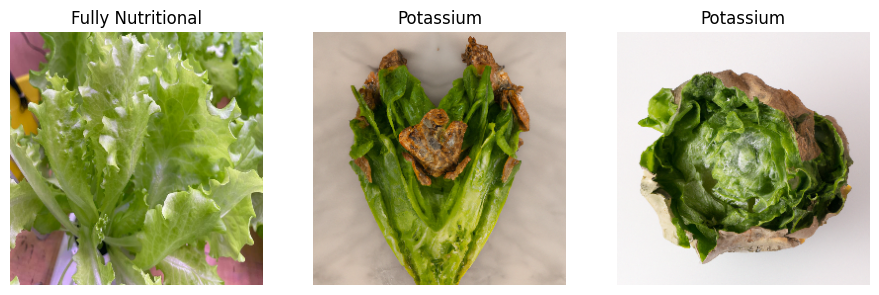

In [13]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(3):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [14]:
len(dataset)

69

In [15]:
train_size = 0.8
len(dataset)*train_size

55.2

In [17]:
train_ds=dataset.take(55)
len(train_ds)

55

In [18]:
test_ds = dataset.skip(55)
len(test_ds)

14

In [19]:
val_size= 0.1
len(dataset)*val_size
val_ds = test_ds.take(14)
len(val_ds)
test_ds = test_ds.skip(14)
len(test_ds)

0

In [20]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle= True, shuffle_size=10000):
        ds_size= len(ds)
        if shuffle:
            ds=ds.shuffle(shuffle_size, seed=12)
        
        train_size = int(train_split*ds_size)
        val_size= int(val_split*ds_size)
        
        train_ds = ds.take(train_size)
        
        val_ds= ds.skip(train_size).take(val_size)
        test_ds= ds.skip(train_size).skip(val_size)
        
        
        return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds= get_dataset_partition_tf(dataset)

In [22]:
len(train_ds)

55

In [23]:
len(val_ds)

6

In [24]:
len(test_ds)

8

In [25]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [26]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [27]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [28]:
#input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
input_shape = (4, 256, 256, 3)
n_classes=4
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape= input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (4, 256, 256, 3)          0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics= ['accuracy']
)

In [31]:
history= model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size= BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
55/55 [==============================] - 26s 322ms/step - loss: 1.3888 - accuracy: 0.2364 - val_loss: 1.4574 - val_accuracy: 0.2083
Epoch 2/50
55/55 [==============================] - 14s 248ms/step - loss: 1.3976 - accuracy: 0.2955 - val_loss: 1.4144 - val_accuracy: 0.2500
Epoch 3/50
55/55 [==============================] - 14s 246ms/step - loss: 1.3640 - accuracy: 0.4591 - val_loss: 1.3631 - val_accuracy: 0.2917
Epoch 4/50
55/55 [==============================] - 14s 246ms/step - loss: 1.3316 - accuracy: 0.3636 - val_loss: 1.1915 - val_accuracy: 0.5833
Epoch 5/50
55/55 [==============================] - 14s 248ms/step - loss: 1.2683 - accuracy: 0.4045 - val_loss: 1.2920 - val_accuracy: 0.2083
Epoch 6/50
55/55 [==============================] - 13s 241ms/step - loss: 1.2229 - accuracy: 0.4182 - val_loss: 1.2119 - val_accuracy: 0.5000
Epoch 7/50
55/55 [==============================] - 13s 243ms/step - loss: 1.0985 - accuracy: 0.4909 - val_loss: 0.8895 - val_accuracy: 0.6250

In [32]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 65ms/step - loss: 0.6797 - accuracy: 0.8750


In [33]:
scores


[0.6796951293945312, 0.875]

In [34]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 55}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
acc = history.history["accuracy"]
val_acc= history.history["val_accuracy"]
loss= history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'training and validation loss')

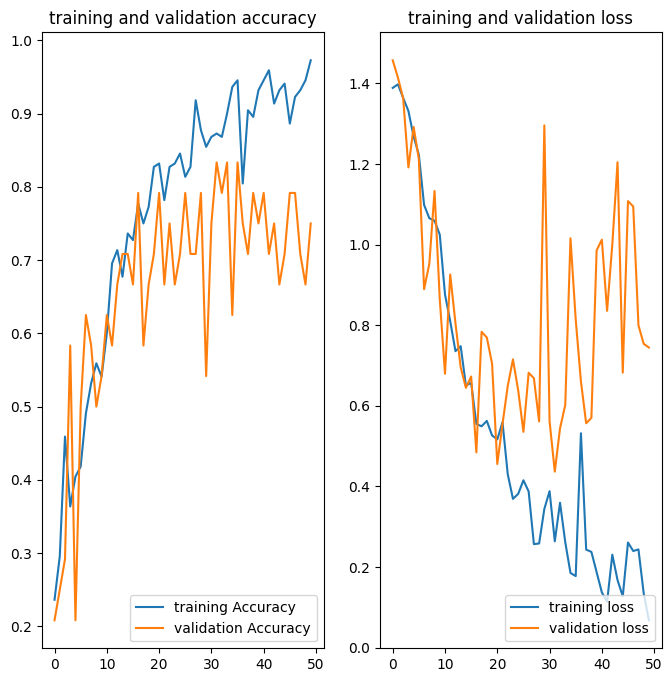

In [37]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label="training Accuracy")
plt.plot(range(EPOCHS),val_acc, label="validation Accuracy")
plt.legend(loc="lower right")
plt.title("training and validation accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label="training loss")
plt.plot(range(EPOCHS),val_loss, label="validation loss")
plt.legend(loc="lower right")
plt.title("training and validation loss")


first image to predict
actual label: Phosphorus
1/1 [==============================] - 0s 200ms/step
predicted label: Potassium


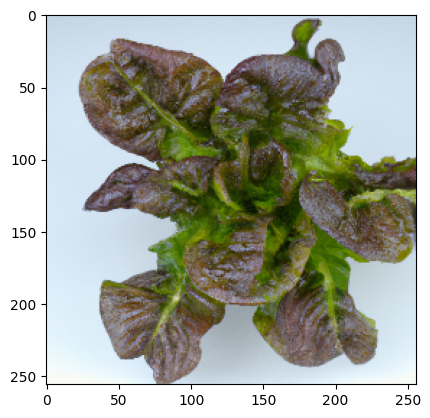

In [38]:
import numpy
for images_batch, labels_batch in test_ds.take(1):
    first_image= (images_batch[0].numpy().astype('uint8'))
    first_label= labels_batch[0]
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction= model.predict(images_batch)
    print("predicted label:", class_names[numpy.argmax(batch_prediction[0])])
    

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)  #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 *(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


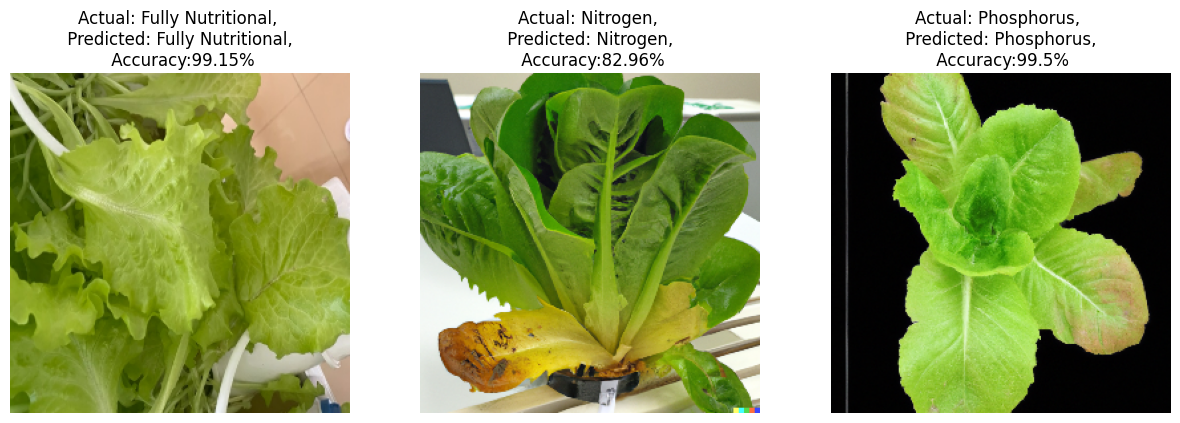

In [40]:
import numpy as np
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(3):
        ax= plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, Accuracy = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Accuracy:{Accuracy}%")
        plt.axis("off")

In [41]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")


INFO:tensorflow:Assets written to: ../models/5\assets


INFO:tensorflow:Assets written to: ../models/5\assets


In [33]:
model.save("../lettuce.h5")